# Text Analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils.analysis_helpers import *

## Choose the data to analyse
- Drop or select specifics conditions
- Differentiate between interviwer & participant

In [3]:
directory = '../Dataset/meditations_transcripts/transcripts_per_interview/csv/**/' 

df_all = load_and_combine_csv(directory)
df_all = standardize_speaker_labels(df_all)
df_all = calculate_word_counts(df_all)

df_all.to_csv("outputs/combined_data.csv", index=False)

Found 82 CSV files.
Calculated 'Word Count' for each 'Content' entry.


In [4]:
print(f"Unique conditions before filtering: {df_all['Condition'].unique()}")
print(f"Number of interviews before filtering: {df_all['File Name'].nunique()}")
# *0*: No "real" interview (e.g., setup phase, small talk). We filter these out.
df_all = df_all[df_all["Condition"] != 0]
print(f"Unique conditions after filtering: {df_all['Condition'].unique()}")
print(f"Number of interviews (File Name) after filtering: {df_all['File Name'].nunique()}")

Unique conditions before filtering: [1 'C' 'I' 0]
Number of interviews before filtering: 82
Unique conditions after filtering: [1 'C' 'I']
Number of interviews (File Name) after filtering: 75


In [5]:
# If we only want to focus on the participant speaker
df_participant = df_all[df_all["Speaker"] == "Participant"].copy()
df_interviewer = df_all[df_all["Speaker"] == "Interviewer"].copy()

## Word Count

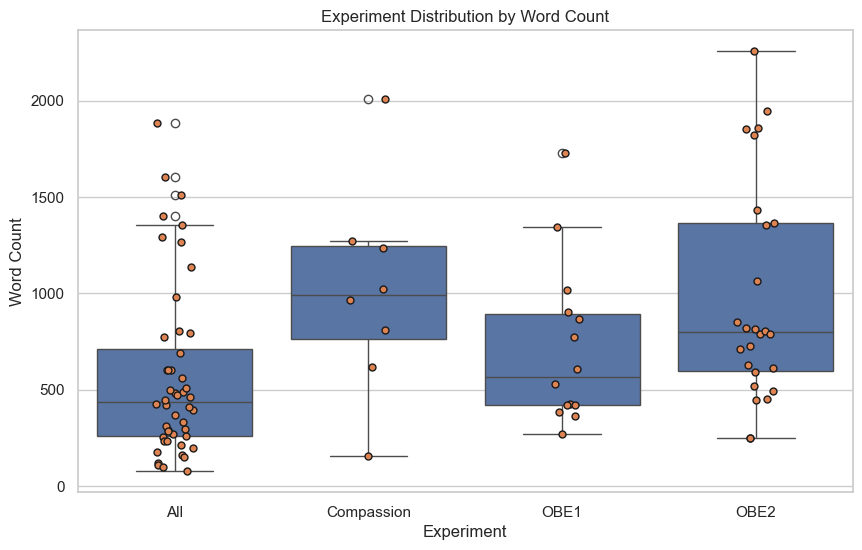

In [6]:
# Add a new row for the "All" category
df_word = aggregate_counts(df_participant,["Experiment","Id"]).copy()
df_word['Experiment'] = 'All'

# Concatenate the original data with the "All" data
df_combined = pd.concat([df_word,aggregate_counts(df_all,["Experiment","Id"])])

stripplot(df_combined, 'Experiment', 'Word Count')

In [7]:
df_pair = aggregate_counts(df_participant, ['Experiment', "Id", "Condition"]).copy()

In [8]:
filter_df = df_pair[df_pair.Condition == 1]
filter_df.sort_values("Word Count", ascending=False)

,Experiment,Id,Condition,Word Count
7,Compassion,306,1,983
10,OBE1,5,1,604
5,Compassion,304,1,561
9,Compassion,313,1,509
0,Compassion,301,1,487
24,OBE1,22,1,481
31,OBE2,203,1,473
62,OBE2,223,1,410
13,OBE1,8,1,367
30,OBE2,202,1,334


In [9]:
import pandas as pd

# Assuming your DataFrame is loaded as `df`
# Example DataFrame structure:
# df = pd.read_csv('your_file.csv')

# Filter only "C" and "I" conditions for comparison
filtered_df = df_pair[df_pair["Condition"].isin(["C", "I"])]

# Calculate the absolute difference in Word Count for each ID and Experiment
comparison = filtered_df.pivot_table(
    index=["Experiment", "Id"], columns="Condition", values="Word Count"
).dropna()

# Add a column for the absolute difference
comparison["Difference"] = abs(comparison["C"] - comparison["I"])

# Sort by the smallest difference to find the most similar pairs
most_similar = comparison.sort_values("Difference")
most_similar


Condition            C       I  Difference
Experiment Id                             
OBE2       214    31.0    46.0        15.0
OBE1       7     393.0   409.0        16.0
Compassion 302   218.0   246.0        28.0
OBE2       208   245.0   202.0        43.0
           220   190.0   236.0        46.0
           207    46.0   115.0        69.0
           206    73.0   158.0        85.0
           211   242.0   150.0        92.0
           228   319.0   456.0       137.0
           227    35.0   198.0       163.0
OBE1       19    485.0   649.0       164.0
OBE2       204   224.0    46.0       178.0
           222   695.0   908.0       213.0
OBE1       24     99.0   321.0       222.0
OBE2       218   191.0   413.0       222.0
           219    34.0   275.0       241.0
           212   147.0   455.0       308.0
           209   838.0   453.0       385.0
           210   138.0   550.0       412.0
           205    34.0   464.0       430.0
           230   157.0   638.0       481.0
Compassion 303   964.0   439.0       525.0
OBE1       13    342.0  1012.0       670.0
OBE2       229   417.0  1095.0       678.0
           225  1264.0     4.0      1260.0
           201   203.0  1680.0      1477.0

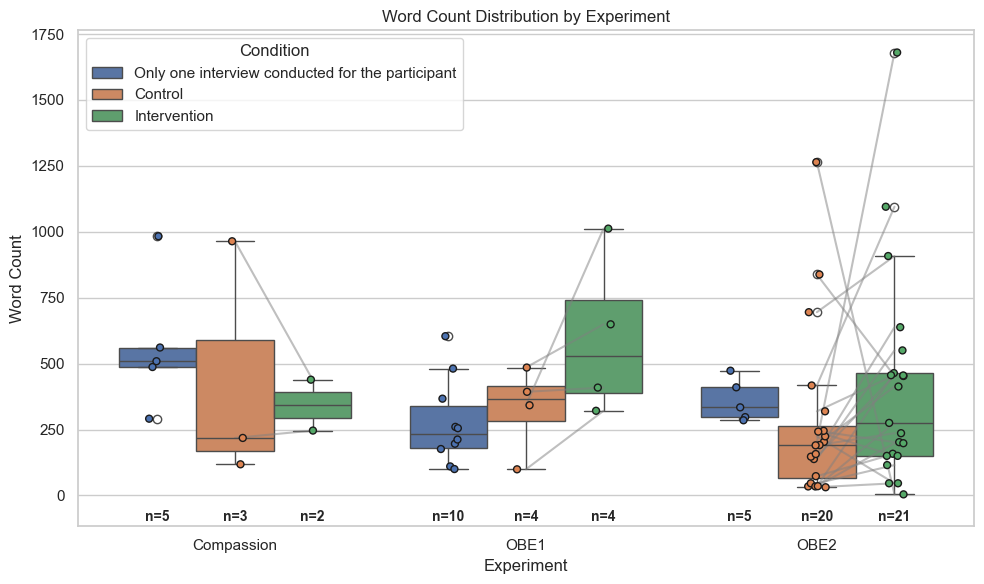

In [10]:
# Group by Id instead of File Name because the same participant can have the same condition in different interviews
stripplot_with_counts(aggregate_counts(df_participant, ['Experiment', "Id", "Condition"]), 'Experiment', 'Word Count', 
                      hue_column='Condition', id_column="Id", legend_labels=["Only one interview conducted for the participant","Control","Intervention"] ,file_name="outputs/stripplot_word_count_id.png")

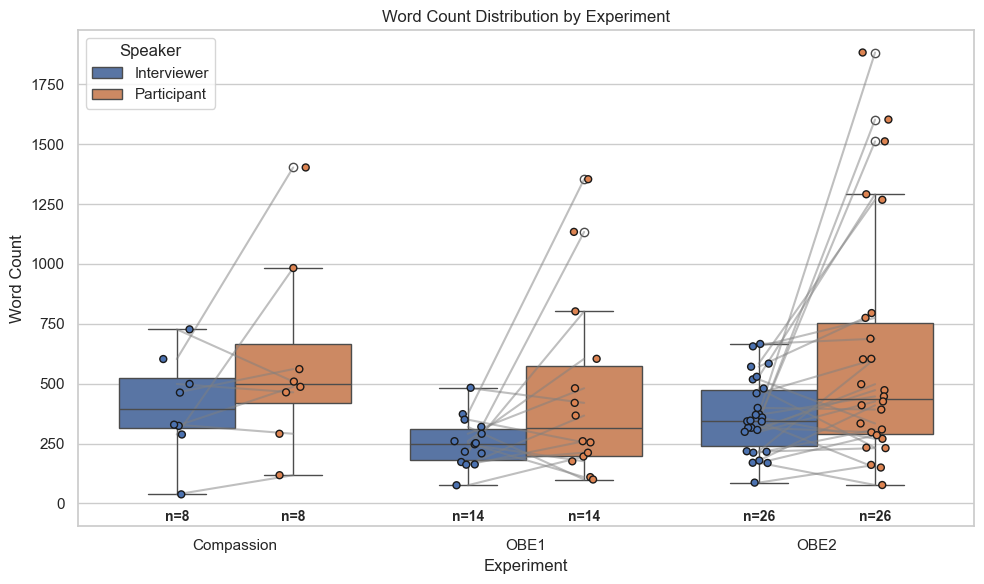

In [11]:
stripplot_with_counts(aggregate_counts(df_all, ['Experiment', "Id", 'Speaker']), 'Experiment', 'Word Count', hue_column='Speaker', id_column="Id")

## Interviewers Distribution

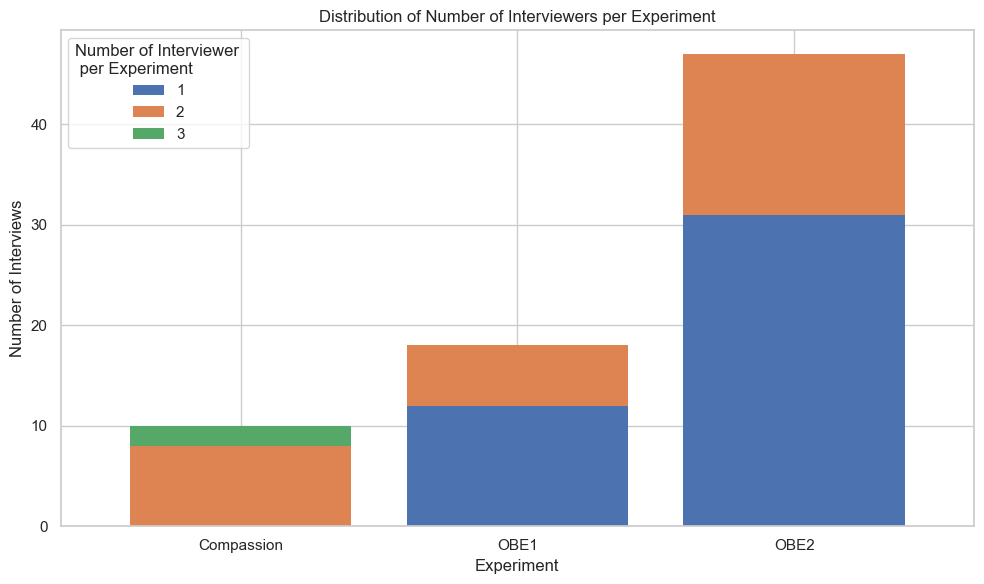

In [12]:
# Step 1: Drop participants and focus on interviewers
filtered_df = df_all[df_all["Speaker_original"].str.contains("Interviewer")]

# Step 2: Count unique interviewers per interview
experimenter_count = (
    filtered_df.groupby(['Experiment', 'File Name'])['Speaker_original']
    .nunique()
    .reset_index()
)
experimenter_count.rename(columns={'Speaker_original': 'Number of Interviewers'}, inplace=True)

# Step 3: Aggregate counts for each experiment and interviewer category
experiment_summary = experimenter_count.groupby(['Experiment', 'Number of Interviewers'])['File Name'].count().reset_index()
experiment_summary.rename(columns={'File Name': 'Count'}, inplace=True)

# Step 4: Ensure all categories are represented
categories = list(range(1, experimenter_count['Number of Interviewers'].max() + 1))  # 1, 2, 3, etc.
all_experiments = experiment_summary['Experiment'].unique()
full_summary = pd.DataFrame(
    [(experiment, category) for experiment in all_experiments for category in categories],
    columns=['Experiment', 'Number of Interviewers']
).merge(experiment_summary, on=['Experiment', 'Number of Interviewers'], how='left').fillna(0)

# Convert counts to integers for clarity
full_summary['Count'] = full_summary['Count'].astype(int)

# Convert the Number of Interviewers to string for grouped bar chart
full_summary['Number of Interviewers'] = full_summary['Number of Interviewers'].astype(str)

# Step 5: Stacked bar chart
stacked_data = full_summary.pivot(index='Experiment', columns='Number of Interviewers', values='Count').fillna(0)
stacked_data.plot(kind='bar', stacked=True, figsize=(10, 6), width=0.8, linewidth=0)

# Add labels and title
plt.title("Distribution of Number of Interviewers per Experiment")
plt.ylabel("Number of Interviews")
plt.xlabel("Experiment")
plt.xticks(rotation=0)
plt.legend(title="Number of Interviewer \n per Experiment")

plt.tight_layout()
plt.show()

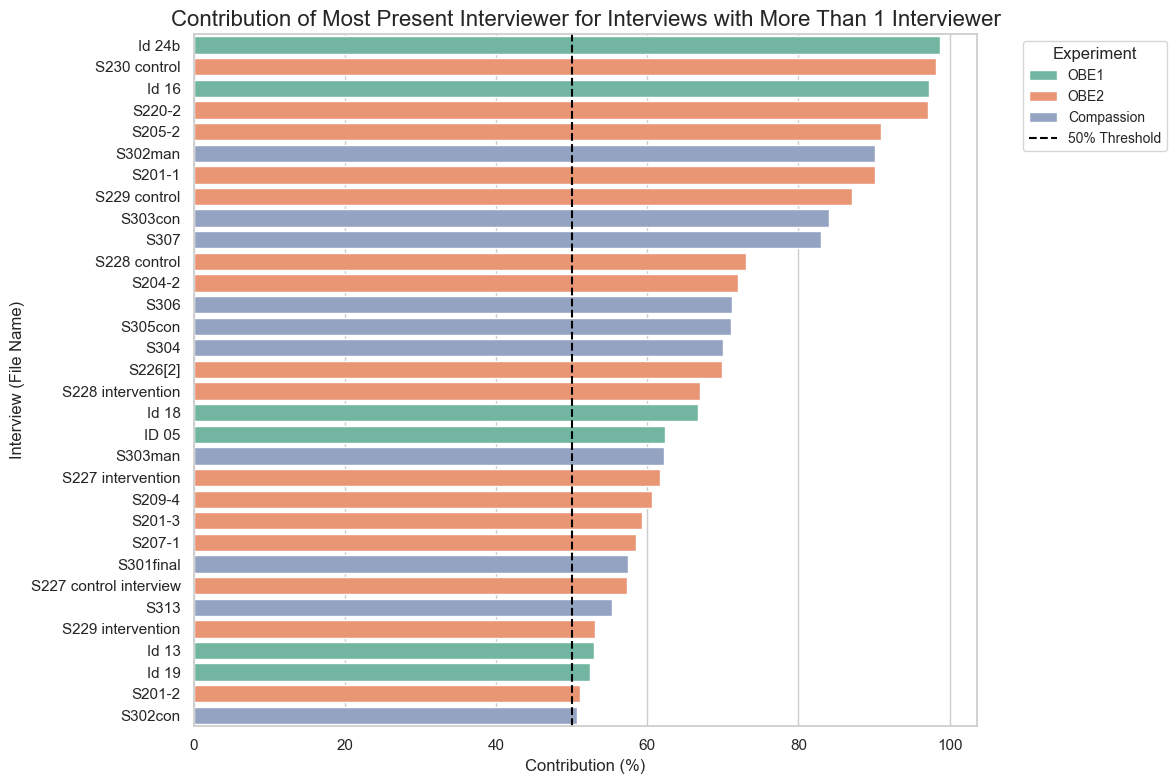

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Drop participants and focus on interviewers
filtered_df = df_all[df_all["Speaker_original"].str.contains("Interviewer")]

# Step 2: Count unique interviewers per interview
experimenter_count = (
    filtered_df.groupby(['Experiment', 'File Name'])['Speaker_original']
    .nunique()
    .reset_index()
)
experimenter_count.rename(columns={'Speaker_original': 'Number of Interviewers'}, inplace=True)

# Step 3: Filter for interviews with more than 1 interviewer
multi_interviewer_files = experimenter_count[experimenter_count['Number of Interviewers'] > 1]
filtered_df = filtered_df[filtered_df['File Name'].isin(multi_interviewer_files['File Name'])]

# Step 4: Calculate total word count per speaker per interview
word_distribution = filtered_df.groupby(['File Name', 'Speaker_original', 'Experiment'])['Word Count'].sum().reset_index()

# Step 5: Calculate dominance (largest contribution)
dominance = word_distribution.groupby(['File Name', 'Experiment'])['Word Count'].max().reset_index()
total_word_count = word_distribution.groupby(['File Name'])['Word Count'].sum().reset_index()
dominance = dominance.merge(total_word_count, on='File Name', how='left')
dominance['Dominance (%)'] = (dominance['Word Count_x'] / dominance['Word Count_y']) * 100
dominance.rename(columns={'Word Count_x': 'Max Contribution', 'Word Count_y': 'Total Words'}, inplace=True)

# Sort by dominance
dominance = dominance.sort_values(by='Dominance (%)', ascending=False)

# Step 6: Plot dominance for interviews with more than 1 interviewer
plt.figure(figsize=(12, 8))
sns.barplot(data=dominance, x='Dominance (%)', y='File Name', hue='Experiment', palette="Set2")

# Add a vertical line at 50% to highlight balance
plt.axvline(50, color='black', linestyle='--', label="50% Threshold")

# Add titles and labels
plt.title("Contribution of Most Present Interviewer for Interviews with More Than 1 Interviewer", fontsize=16)
plt.xlabel("Contribution (%)", fontsize=12)
plt.ylabel("Interview (File Name)", fontsize=12)
plt.legend(title="Experiment", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

Simplest version for the power-point

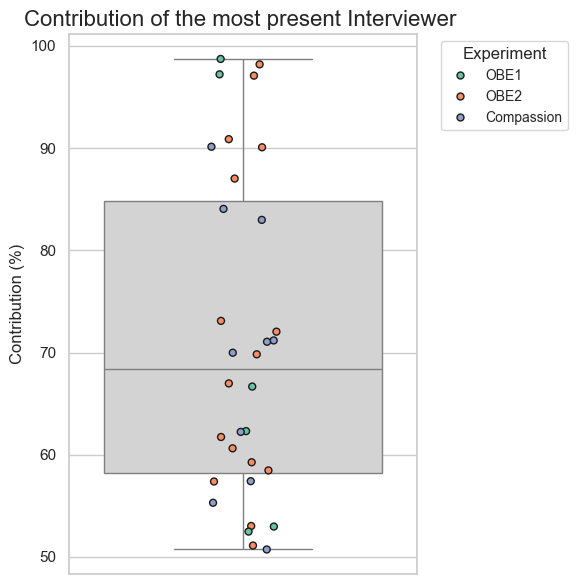

In [14]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=dominance, y='Dominance (%)', color='lightgray')
sns.stripplot(data=dominance, y='Dominance (%)', hue="Experiment", jitter=True, edgecolor='k', linewidth=1, palette="Set2")

# Add titles and labels
plt.title("Contribution of the most present Interviewer ", fontsize=16)
plt.ylabel("Contribution (%)", fontsize=12)
# put legend outside of the plot
plt.legend(title="Experiment", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig("outputs/contribution_interviewer.png", dpi=600)
plt.show()

In [15]:
# Step 1: Filter out participants and focus on interviewers
filtered_df = df_all[df_all["Speaker_original"].str.contains("Interviewer")]

# Step 2: Count the number of unique interviewers for each interview
interviewer_counts = (
    filtered_df.groupby(['Id', 'File Name'])['Speaker_original']
    .nunique()
    .reset_index()
)
interviewer_counts.rename(columns={'Speaker_original': 'Number of Interviewers'}, inplace=True)

# Step 3: Check changes in the number of interviewers for each participant (ID)
participant_interviewer_changes = (
    interviewer_counts.groupby('Id')['Number of Interviewers']
    .nunique()
    .reset_index()
)
participant_interviewer_changes.rename(columns={'Number of Interviewers': 'Unique Interviewer Counts'}, inplace=True)

# Step 4: Identify participants with changes in interviewer counts across their interviews
participants_with_changes = participant_interviewer_changes[
    participant_interviewer_changes['Unique Interviewer Counts'] > 1
]

# Step 5: Display results
if participants_with_changes.empty:
    print("All participants have consistent numbers of interviewers across their interviews.")
else:
    print("The following participants have varying numbers of interviewers across their interviews:")
    print(participants_with_changes)

# Optional: Display detailed changes per ID
detailed_changes = interviewer_counts[interviewer_counts['Id'].isin(participants_with_changes['Id'])]
print("\nDetailed changes for inconsistent participants:")
print(detailed_changes.sort_values(by=['Id', 'File Name']))

The following participants have varying numbers of interviewers across their interviews:
     Id  Unique Interviewer Counts
3    13                          2
9    19                          2
13   24                          2
17  204                          2
18  205                          2
20  207                          2
22  209                          2
31  220                          2
39  230                          2
41  302                          2

Detailed changes for inconsistent participants:
     Id          File Name  Number of Interviewers
4    13              Id 13                       2
5    13             Id 13b                       1
11   19              Id 19                       2
12   19             Id 19b                       1
16   24              Id 24                       1
17   24             Id 24b                       2
23  204             S204-1                       1
24  204             S204-2                       2
25  205           

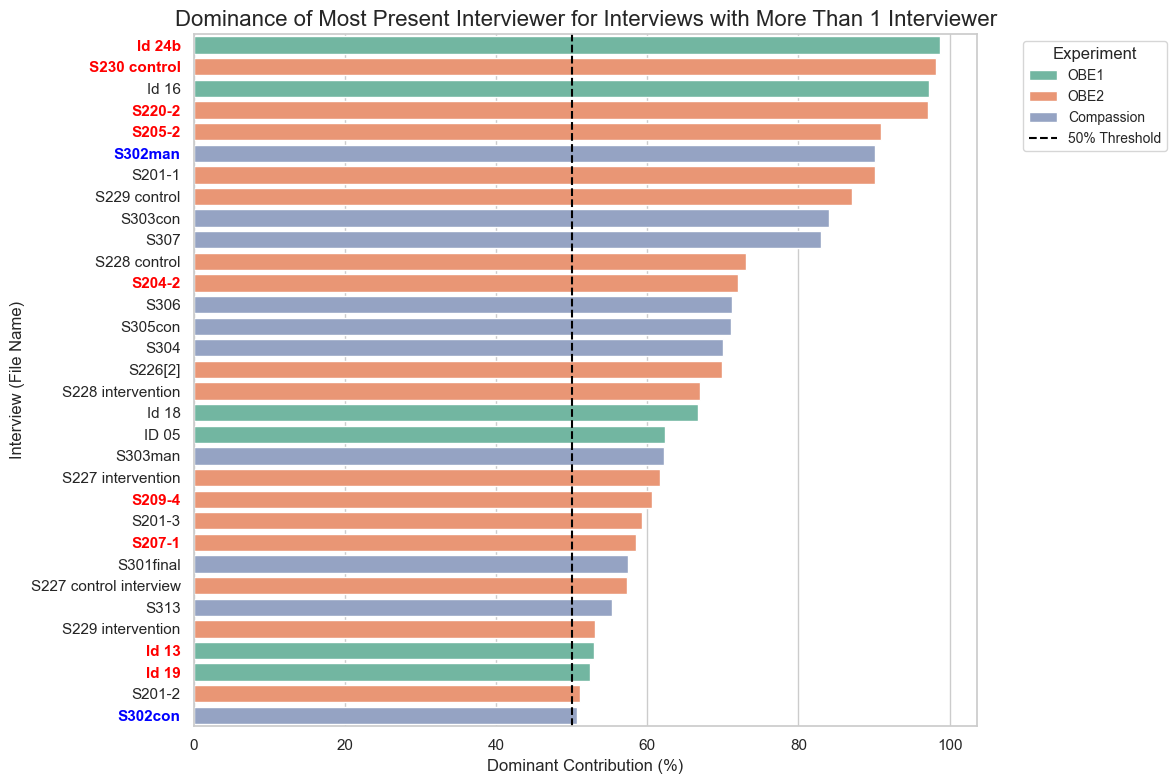

In [16]:
# Step 1: Drop participants and focus on interviewers
filtered_df = df_all[df_all["Speaker_original"].str.contains("Interviewer")]

# Step 2: Count unique interviewers per interview
experimenter_count = (
    filtered_df.groupby(['Experiment', 'File Name'])['Speaker_original']
    .nunique()
    .reset_index()
)
experimenter_count.rename(columns={'Speaker_original': 'Number of Interviewers'}, inplace=True)

# Step 3: Filter for interviews with more than 1 interviewer
multi_interviewer_files = experimenter_count[experimenter_count['Number of Interviewers'] > 1]
filtered_df = filtered_df[filtered_df['File Name'].isin(multi_interviewer_files['File Name'])]

# Step 4: Calculate total word count per speaker per interview
word_distribution = filtered_df.groupby(['File Name', 'Speaker_original', 'Experiment'])['Word Count'].sum().reset_index()

# Step 5: Calculate dominance (largest contribution)
dominance = word_distribution.groupby(['File Name', 'Experiment'])['Word Count'].max().reset_index()
total_word_count = word_distribution.groupby(['File Name'])['Word Count'].sum().reset_index()
dominance = dominance.merge(total_word_count, on='File Name', how='left')
dominance['Dominance (%)'] = (dominance['Word Count_x'] / dominance['Word Count_y']) * 100
dominance.rename(columns={'Word Count_x': 'Max Contribution', 'Word Count_y': 'Total Words'}, inplace=True)

# Sort by dominance
dominance = dominance.sort_values(by='Dominance (%)', ascending=False)

# Step 6: Identify interviews to highlight
inconsistent_interviews = detailed_changes['File Name'].unique()  # From earlier inconsistent participant analysis
special_case = 'S302'  # Special case to highlight differently

# Step 7: Plot dominance for interviews with more than 1 interviewer
plt.figure(figsize=(12, 8))
barplot = sns.barplot(data=dominance, x='Dominance (%)', y='File Name', hue='Experiment', palette="Set2")

# Add a vertical line at 50% to highlight balance
plt.axvline(50, color='black', linestyle='--', label="50% Threshold")

# Customize y-axis tick labels
for tick, label in zip(barplot.get_yticks(), barplot.get_yticklabels()):
    file_name = label.get_text()
    if file_name in inconsistent_interviews and special_case not in file_name :
        label.set_color('red')  # Highlight inconsistent interviews in red
        label.set_fontweight('bold')
    elif special_case in file_name:
        label.set_color('blue')  # Highlight the special case in blue
        label.set_fontweight('bold')

# Add titles and labels
plt.title("Dominance of Most Present Interviewer for Interviews with More Than 1 Interviewer", fontsize=16)
plt.xlabel("Dominant Contribution (%)", fontsize=12)
plt.ylabel("Interview (File Name)", fontsize=12)
plt.legend(title="Experiment", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

Simplest version for the power-point

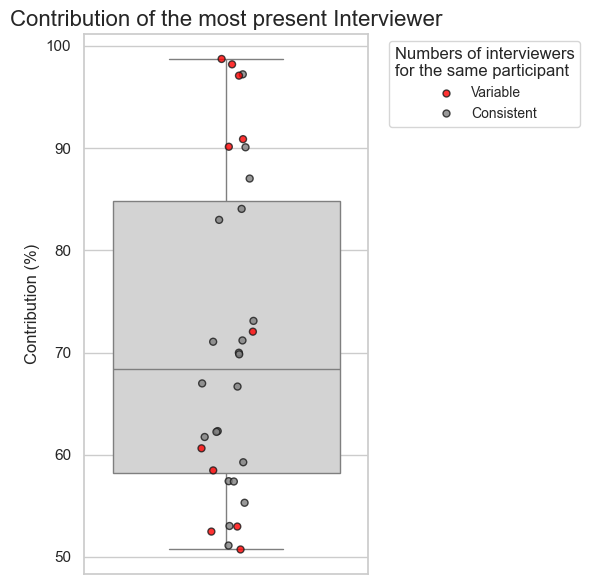

In [17]:
# Add a new column to classify the points for hue
dominance['Highlight'] = dominance['File Name'].apply(
    lambda x: 'Variable' if special_case in x or x in inconsistent_interviews else 
              'Consistent'
)

plt.figure(figsize=(6, 6))

# Step 1: Create a base boxplot
sns.boxplot(data=dominance, y='Dominance (%)', color='lightgray')

# Step 2: Add a stripplot with hue for highlighting
sns.stripplot(
    data=dominance,
    y='Dominance (%)',
    hue='Highlight',  # Use the new column to distinguish points
    jitter=True,
    edgecolor='k',
    linewidth=1,
    alpha=0.8,
    palette={'Variable': 'red', 'Consistent': 'gray'},
)

# Step 3: Titles and labels
plt.title("Contribution of the most present Interviewer", fontsize=16)
plt.ylabel("Contribution (%)", fontsize=12)

# Step 4: Adjust legend
plt.legend(title="Numbers of interviewers\nfor the same participant", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Step 5: Tight layout and save
plt.tight_layout()
plt.savefig("outputs/contribution_interviewer_highlighted.png", dpi=600)
plt.show()


<Figure size 1200x600 with 0 Axes>

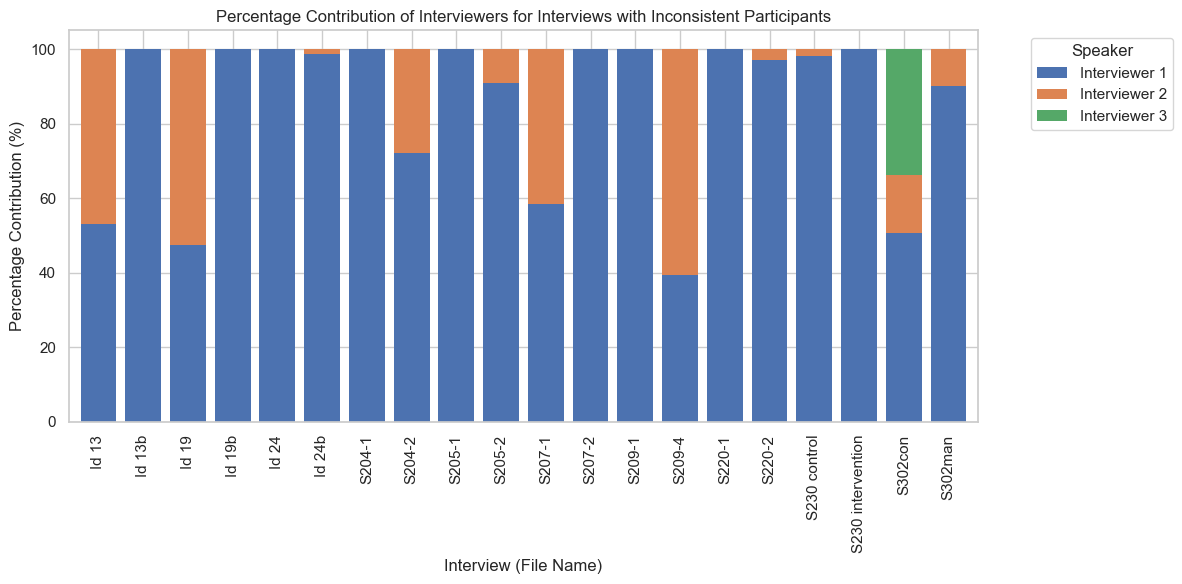

In [18]:
# Step 1: Filter out participants and focus on interviewers
filtered_df = df_all[df_all["Speaker_original"].str.contains("Interviewer")]

# Step 2: Count the number of unique interviewers for each interview
interviewer_counts = (
    filtered_df.groupby(['Id', 'File Name'])['Speaker_original']
    .nunique()
    .reset_index()
)
interviewer_counts.rename(columns={'Speaker_original': 'Number of Interviewers'}, inplace=True)

# Step 3: Check changes in the number of interviewers for each participant (ID)
participant_interviewer_changes = (
    interviewer_counts.groupby('Id')['Number of Interviewers']
    .nunique()
    .reset_index()
)
participant_interviewer_changes.rename(columns={'Number of Interviewers': 'Unique Interviewer Counts'}, inplace=True)

# Step 4: Identify participants with changes in interviewer counts across their interviews
participants_with_changes = participant_interviewer_changes[
    participant_interviewer_changes['Unique Interviewer Counts'] > 1
]

# Step 5: Filter detailed changes for inconsistent participants
detailed_changes = interviewer_counts[interviewer_counts['Id'].isin(participants_with_changes['Id'])]

# Step 6: Filter the main DataFrame for inconsistent participants
inconsistent_interviews = filtered_df[filtered_df['Id'].isin(participants_with_changes['Id'])]

# Step 7: Calculate total word count per speaker per interview
word_distribution = inconsistent_interviews.groupby(['File Name', 'Speaker_original'])['Word Count'].sum().reset_index()

# Step 8: Calculate total word count per interview
total_words_per_interview = word_distribution.groupby('File Name')['Word Count'].sum().reset_index()
total_words_per_interview.rename(columns={'Word Count': 'Total Words'}, inplace=True)

# Step 9: Merge total word counts to calculate percentages
word_distribution = word_distribution.merge(total_words_per_interview, on='File Name')
word_distribution['Percentage'] = (word_distribution['Word Count'] / word_distribution['Total Words']) * 100

# Step 10: Pivot to create a DataFrame with rows as interviews and columns as speakers
word_distribution_pivot = word_distribution.pivot(index='File Name', columns='Speaker_original', values='Percentage').fillna(0)

# Step 11: Plot stacked bar chart for inconsistent interviews
plt.figure(figsize=(12, 6))
word_distribution_pivot.plot(kind="bar", stacked=True, figsize=(12, 6), width=0.8, linewidth=0)

# Add titles and labels
plt.title("Percentage Contribution of Interviewers for Interviews with Inconsistent Participants")
plt.xlabel("Interview (File Name)")
plt.ylabel("Percentage Contribution (%)")
plt.xticks(rotation=90, ha="center")
plt.legend(title="Speaker", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Display the plot
plt.show()

<Figure size 1200x600 with 0 Axes>

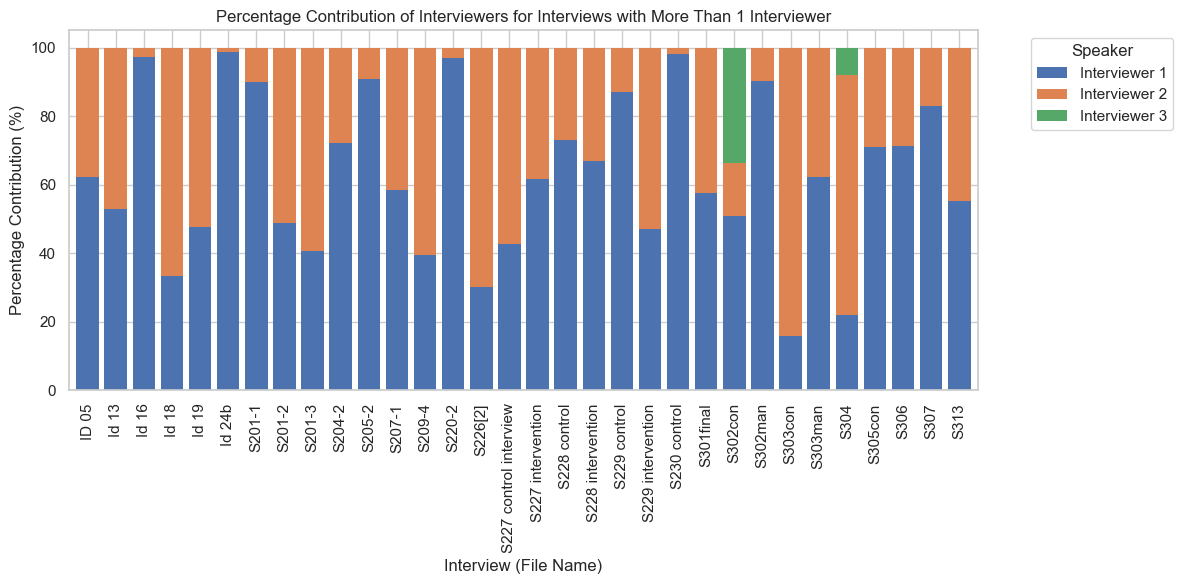

In [19]:
# Step 1: Filter out participants and focus on interviewers
filtered_df = df_all[df_all["Speaker_original"].str.contains("Interviewer")]

# Step 2: Count unique interviewers per interview and filter for interviews with more than 1 interviewer
experimenter_count = (
    filtered_df.groupby(['File Name'])['Speaker_original']
    .nunique()
    .reset_index()
)
experimenter_count.rename(columns={'Speaker_original': 'Number of Interviewers'}, inplace=True)

# Step 3: Filter for interviews with more than 1 interviewer
multi_interviewer_files = experimenter_count[experimenter_count['Number of Interviewers'] > 1]['File Name']
filtered_df = filtered_df[filtered_df['File Name'].isin(multi_interviewer_files)]

# Step 4: Calculate total word count per speaker per interview
word_distribution = filtered_df.groupby(['File Name', 'Speaker_original'])['Word Count'].sum().reset_index()

# Step 5: Calculate total word count per interview
total_words_per_interview = word_distribution.groupby('File Name')['Word Count'].sum().reset_index()
total_words_per_interview.rename(columns={'Word Count': 'Total Words'}, inplace=True)

# Step 6: Merge total word counts to calculate percentages
word_distribution = word_distribution.merge(total_words_per_interview, on='File Name')
word_distribution['Percentage'] = (word_distribution['Word Count'] / word_distribution['Total Words']) * 100

# Step 7: Pivot to create a DataFrame with rows as interviews and columns as speakers
word_distribution_pivot = word_distribution.pivot(index='File Name', columns='Speaker_original', values='Percentage').fillna(0)

# Step 8: Plot stacked bar chart for interviews with more than 1 interviewer
plt.figure(figsize=(12, 6))
word_distribution_pivot.plot(kind="bar", stacked=True, figsize=(12, 6), width=0.8,linewidth=0)

# Add titles and labels
plt.title("Percentage Contribution of Interviewers for Interviews with More Than 1 Interviewer")
plt.xlabel("Interview (File Name)")
plt.ylabel("Percentage Contribution (%)")
plt.xticks(rotation=90, ha="center")
plt.legend(title="Speaker", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Display the plot
plt.show()

## Frequency & Unique Words

In [20]:
extra_stopwords = [
    # Filler Words: Common conversational placeholders without thematic value
    "yeah", "okay", "yes", "mean", "oh", "ah", "like","see",
    # Vague/Ambiguous Words: Frequent but thematically irrelevant in conversations
    "think", "know", "really", "bit", "feel", "thing", "sort", "maybe", "little"
]

# Remove from the default stopwords list (spacy)
retain_stopwords=["see", "yourself", "myself"]

df_participant['preprocessed_content'] = df_participant['Content'].apply(lambda x: preprocess_text(x, extra_stopwords=extra_stopwords,retain_stopwords=retain_stopwords))

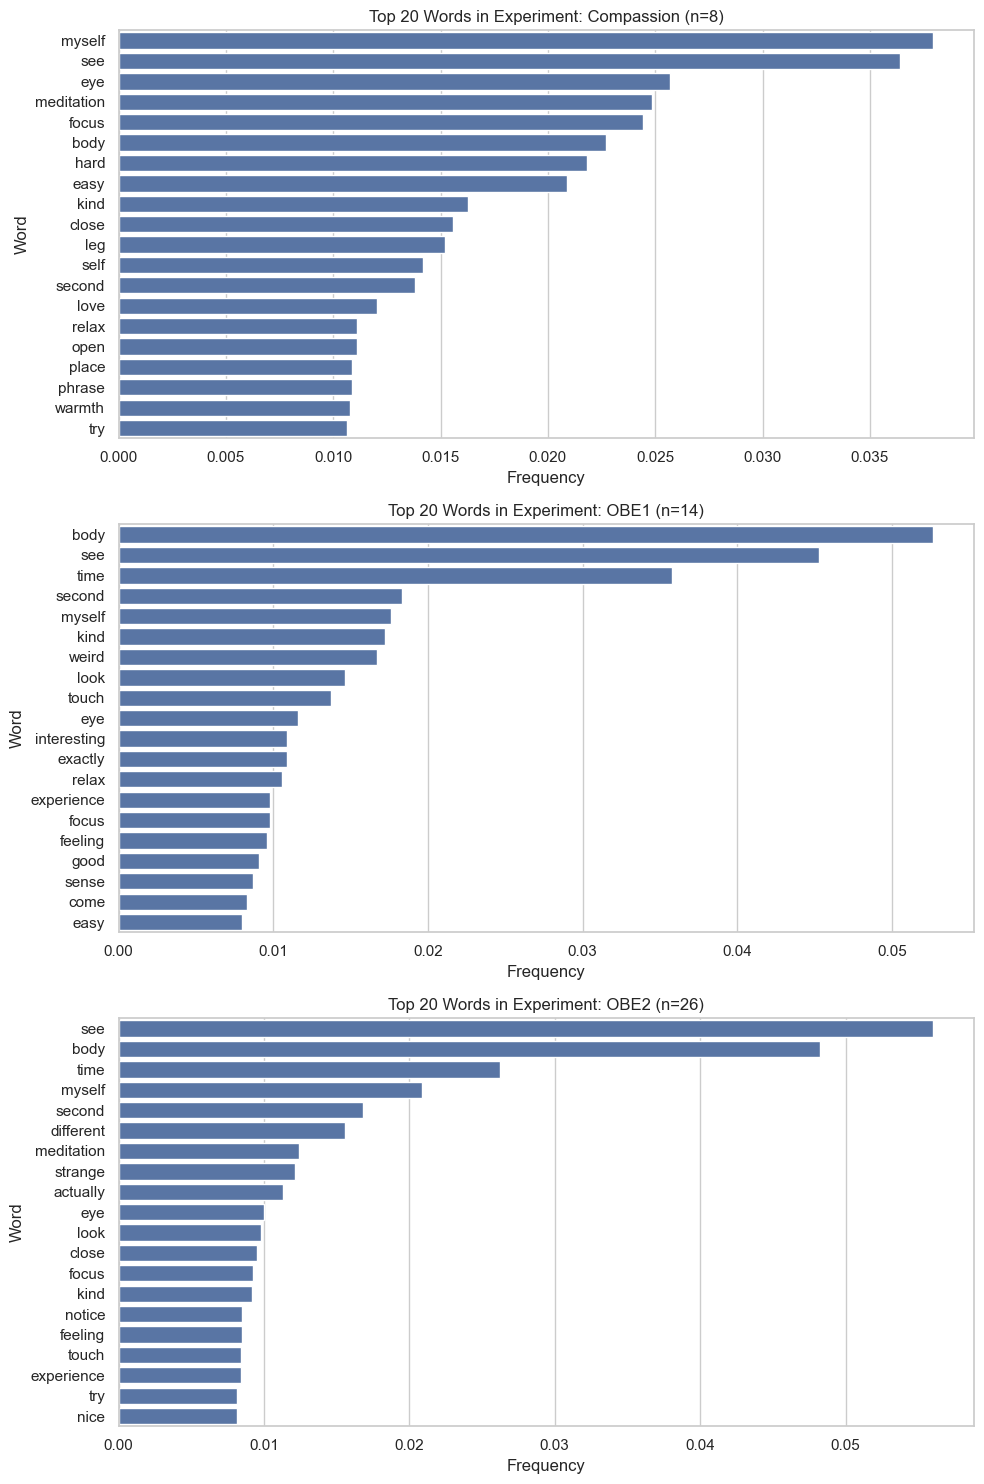

In [21]:
words_feq = count_word_frequencies(df_participant, groupby_columns=['Id','Experiment'], normalize=True)
plot_word_frequencies(words_feq, groupby_column='Experiment', level_column='Id')

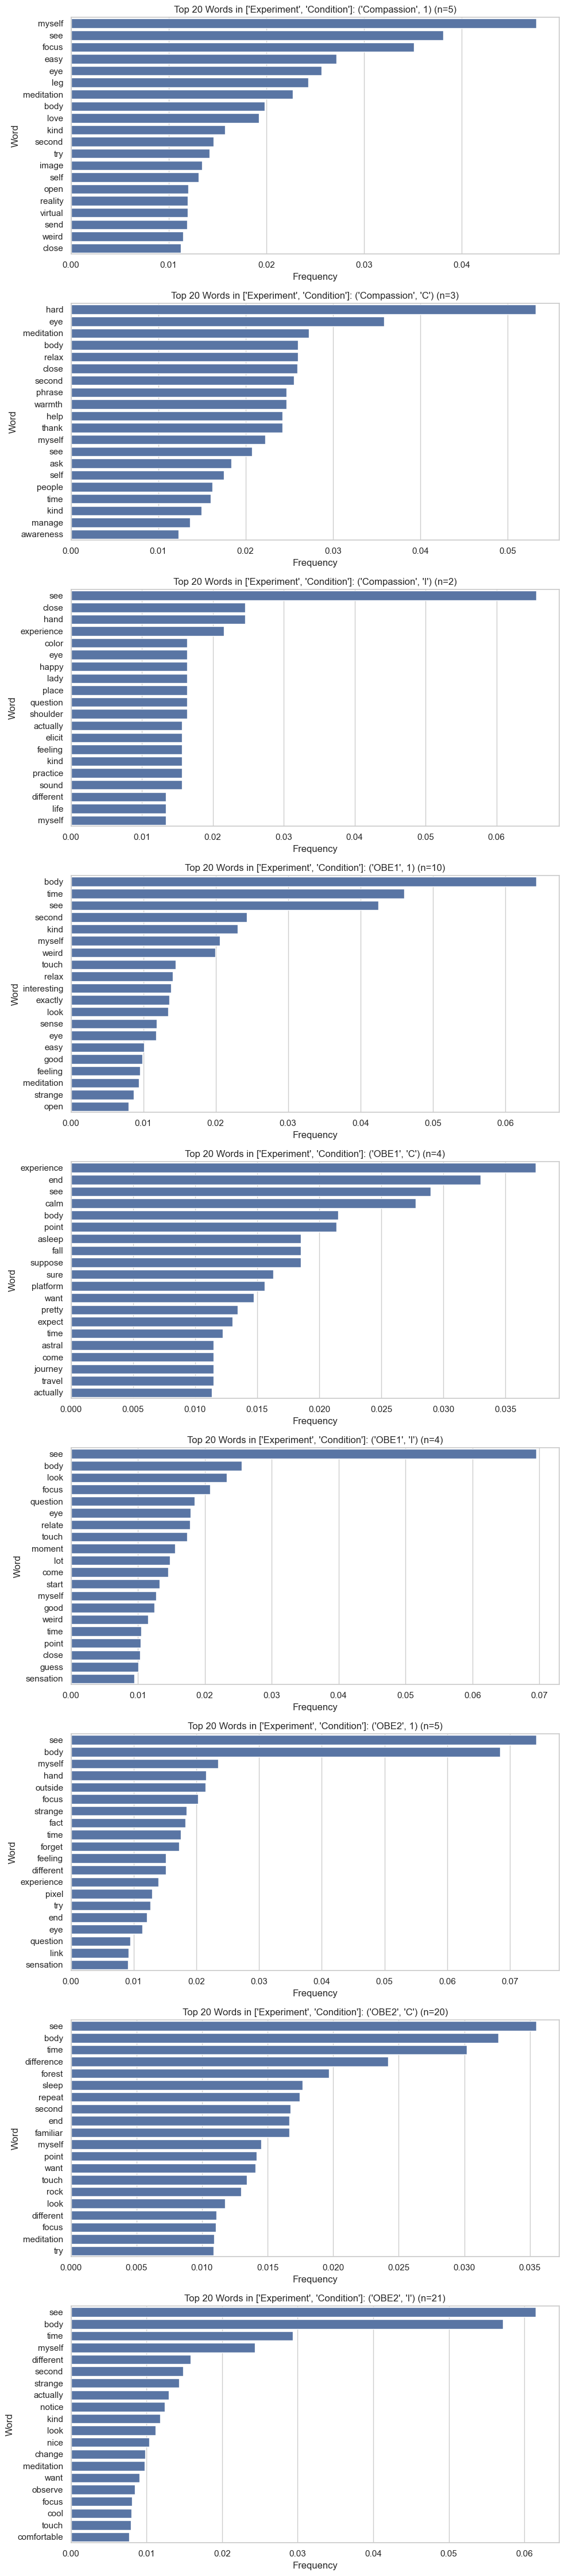

In [22]:
words_feq = count_word_frequencies(df_participant, groupby_columns=['File Name','Experiment','Condition'], normalize=True)
plot_word_frequencies(words_feq, groupby_column=['Experiment','Condition'], level_column='File Name')

### Shared participants uniques words 

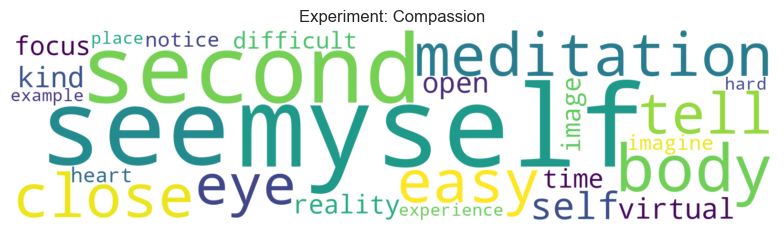

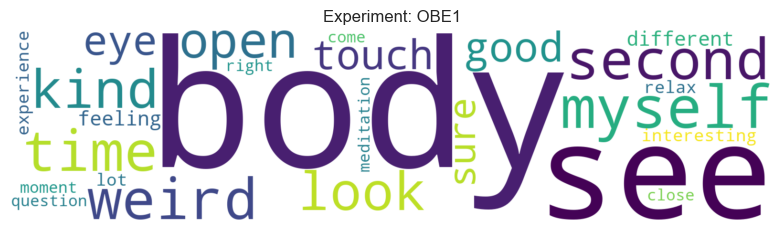

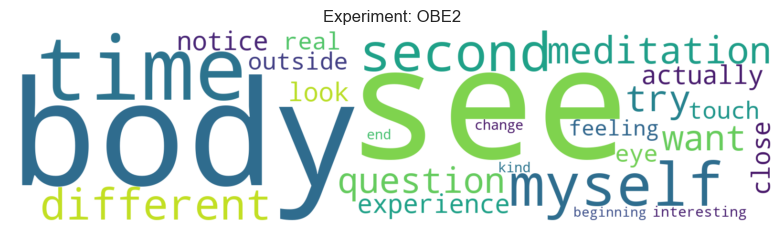

In [23]:
# You can specify any list of columns for grouping, e.g., ['Experiment', 'Condition']
unique_words_df_participant = count_unique_words(df_participant, groupby_columns=['Experiment'])#, 'Condition'])
unique_words_df_participant = unique_words_df_participant.sort_values(by='Participant_Count', ascending=False)
unique_words_df_participant.to_csv("outputs/unique_words_participant.csv", index=False)

generate_word_clouds(unique_words_df_participant, max_words=25, groupby_columns=['Experiment'])#,"Condition"])

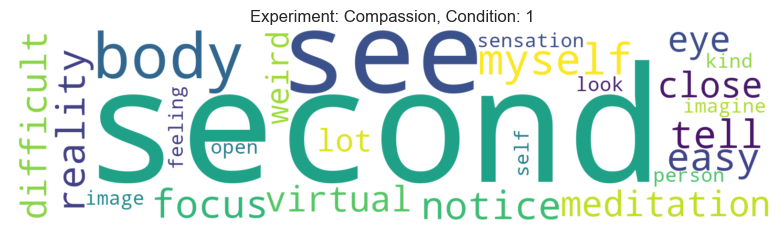

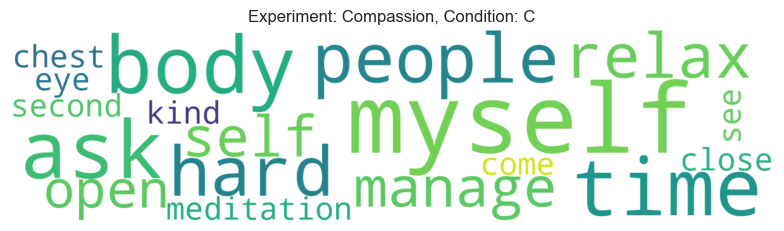

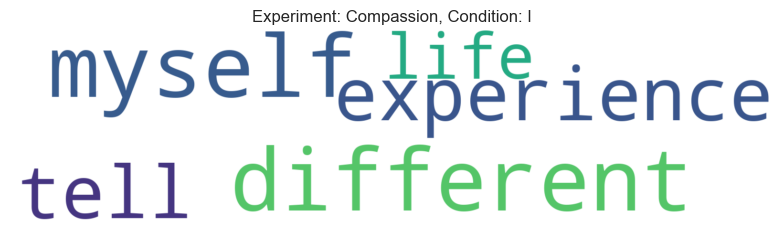

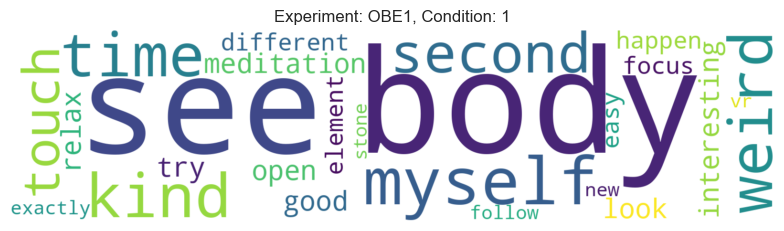

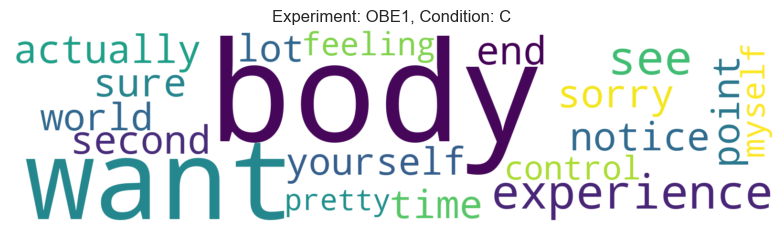

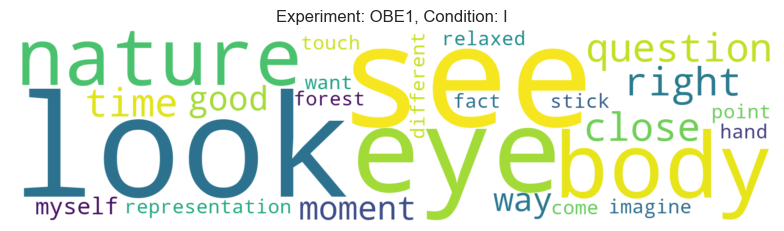

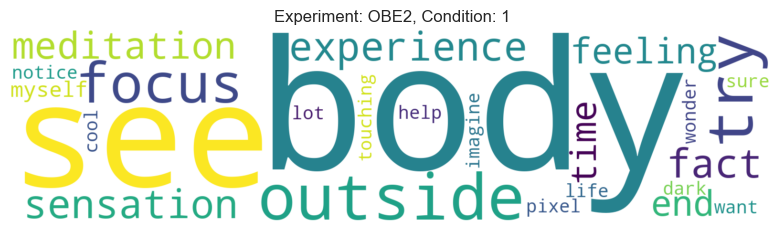

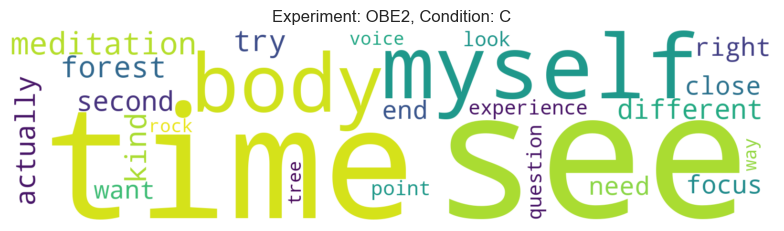

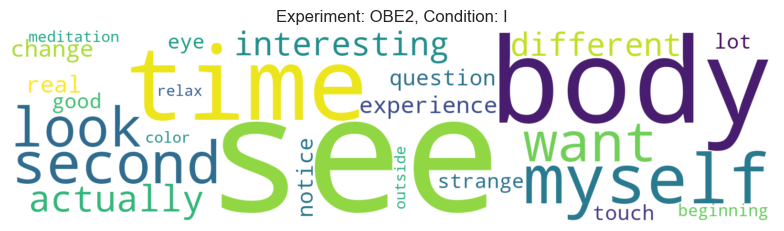

In [24]:
# You can specify any list of columns for grouping, e.g., ['Experiment', 'Condition']
unique_words_df_participant = count_unique_words(df_participant, groupby_columns=['Experiment', 'Condition'])
unique_words_df_participant = unique_words_df_participant.sort_values(by='Participant_Count', ascending=False)
unique_words_df_participant.to_csv("outputs/unique_words_participant.csv", index=False)

generate_word_clouds(unique_words_df_participant, max_words=25, groupby_columns=['Experiment',"Condition"])

### Merged OBE1 and OBE2

In [25]:
# Drop the row witcompassion experiments
df_participant_merged_OBE = df_participant.copy()
df_participant_merged_OBE.Experiment = df_participant_merged_OBE.Experiment.replace({"OBE1": "OBE", "OBE2": "OBE"})

df_participant_merged_OBE.Experiment.unique()

array(['Compassion', 'OBE'], dtype=object)

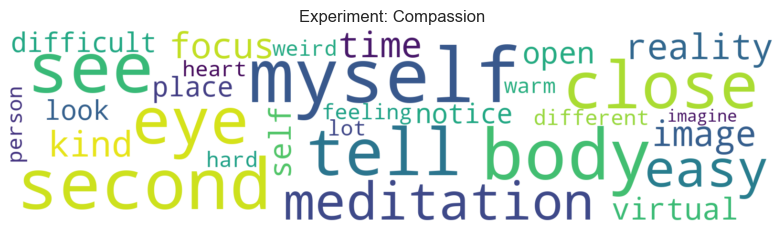

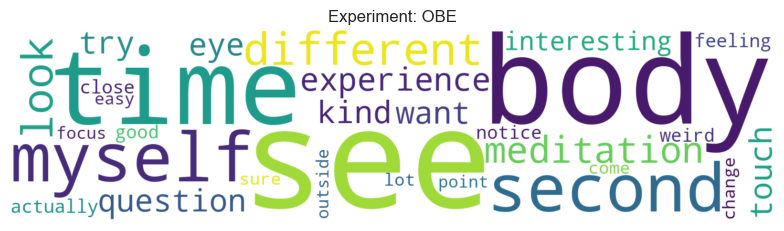

In [26]:
# You can specify any list of columns for grouping, e.g., ['Experiment', 'Condition']
unique_words_df_participant = count_unique_words(df_participant_merged_OBE, groupby_columns=['Experiment'])#, 'Condition'])
unique_words_df_participant = unique_words_df_participant.sort_values(by='Participant_Count', ascending=False)
unique_words_df_participant.to_csv("outputs/unique_words_participant.csv", index=False)

generate_word_clouds(unique_words_df_participant, max_words=30, groupby_columns=['Experiment'], save_fig=True)#,"Condition"])

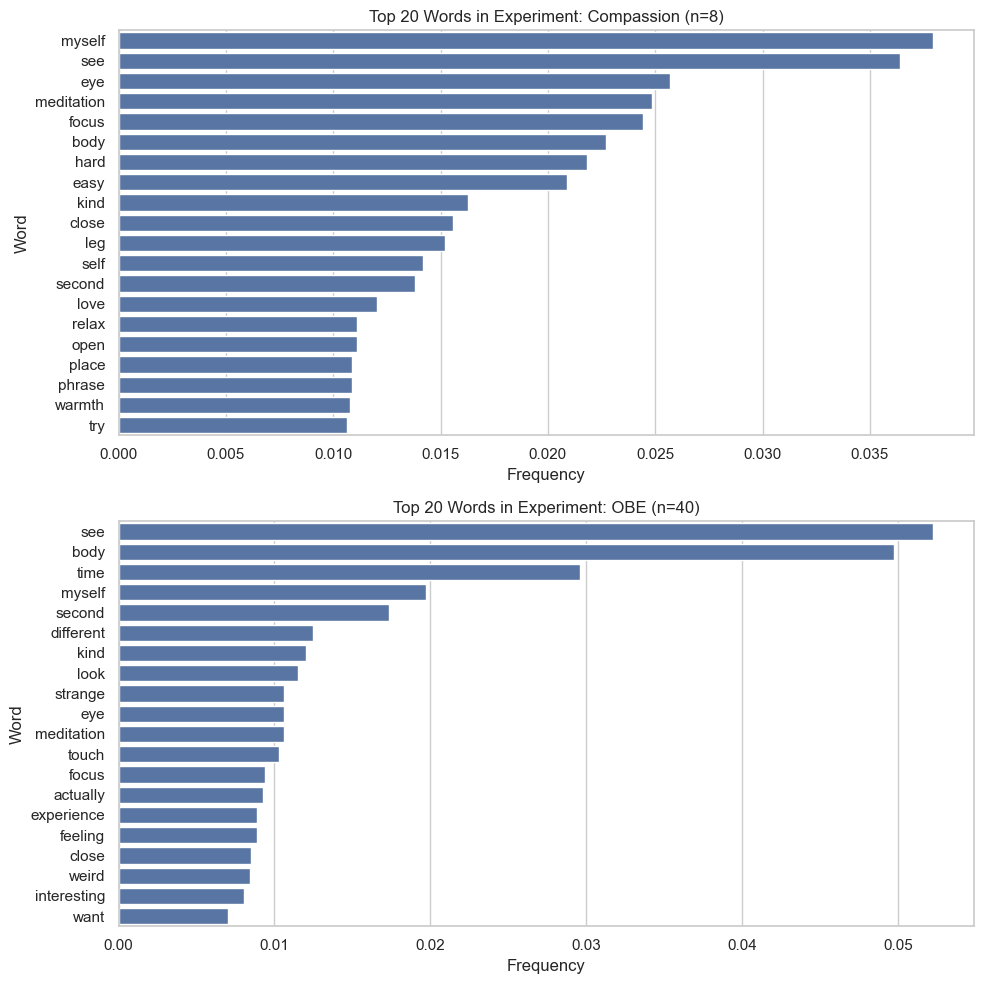

In [27]:
words_feq = count_word_frequencies(df_participant_merged_OBE, groupby_columns=['Id','Experiment'], normalize=True)
plot_word_frequencies(words_feq, groupby_column='Experiment', level_column='Id')

### Shared Interviewers uniques words

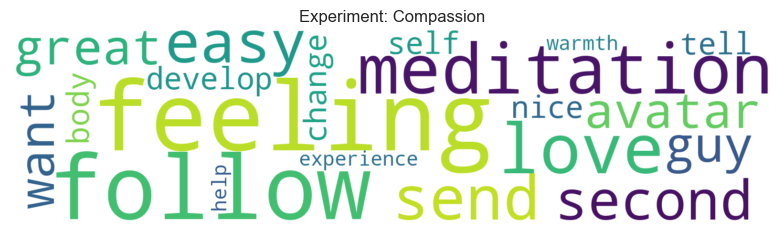

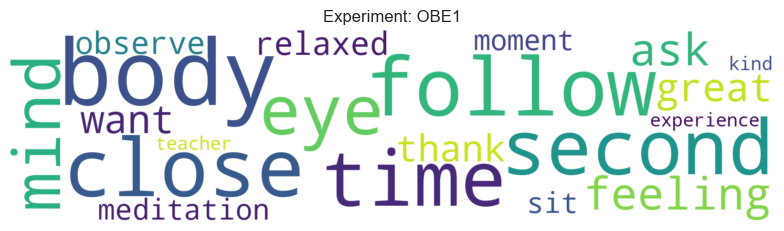

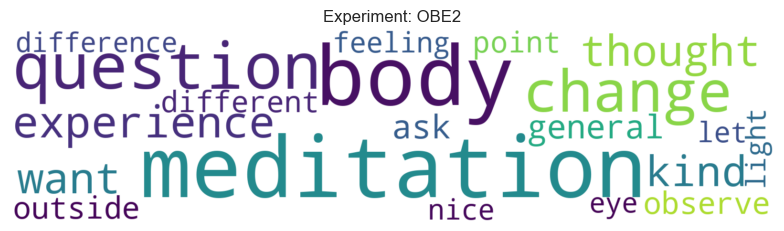

In [28]:
df_interviewer['preprocessed_content'] = df_interviewer['Content'].apply(lambda x: preprocess_text(x, extra_stopwords=extra_stopwords))

unique_words_df_interviewer = count_unique_words(df_interviewer, groupby_columns=['Experiment'])#, 'Condition'])
unique_words_df_interviewer = unique_words_df_interviewer.sort_values(by='Participant_Count', ascending=False)
unique_words_df_interviewer.to_csv("outputs/unique_words_interviewer.csv", index=False)

generate_word_clouds(unique_words_df_interviewer, groupby_columns=['Experiment'], max_words=20)